In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from algbench import read_as_pandas

font = {'family': 'serif', 'size': 11}
matplotlib.rc('font', **font)

"""
QTG: #089099 - PPQAgreen
QTG non-biased: #7CCBA2 - PPQAlightgreen
Grover:#F0746E - PPQAorange
Nested Q Search:#DC3977 - PPQApink
QBnB:#7C1D6F - PPQApurple
"""
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=[
    "#089099",
    "#7CCBA2",
    "#F0746E",
    "#DC3977"
])

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = [9, 3.5]

In [18]:
paths = ['classical_qtg_comparison/small', 'classical_qtg_comparison/large']

qtg_results = pd.concat([read_as_pandas(f'results/quantum_benchmark/{path}', lambda row: {
    'algorithm': 'QTG',
    'size': row['parameters']['args']['instance']['size'],
    'instance': row['parameters']['args']['instance']['name'],
    'grover_iterations': row['parameters']['args']['alg_params']['qtg_iterations'],
}) for path in paths])

instances = pd.concat([read_as_pandas(f'results/classical_benchmark/{path}', lambda row: {
    'instance': row['parameters']['args']['instance']['name'],
    'items': row['parameters']['args']['instance']['items'],
    'capacity': row['parameters']['args']['instance']['capacity'],
    'item_assignment': row['result']['item_assignments'],
} if row['parameters']['args']['solver'] == "combo" else None) for path in paths])


In [23]:
break_items = dict()
prob_of_opt = dict()
for _, row in instances.iterrows():
    remaining_capacity = row['capacity']

    for i, item in enumerate(row['items']):
        if item['cost'] > remaining_capacity:
            break_items[row['instance']] = i
        remaining_capacity -= item['cost']
    
    current_probability = 1
    remaining_capacity = row['capacity']
    for i, item in enumerate(row['items']):
        if item['cost'] <= remaining_capacity:
            # item can be picked or not
            current_probability /= 2
            remaining_capacity -= item['cost']
    
    prob_of_opt[row['instance']] = current_probability

    assert remaining_capacity >= 0
    assert row['instance'] in break_items

In [24]:
grover_iteration_dfs = pd.concat([
    pd.DataFrame({
        "algorithm": "Nested Q Search",
        "size": list(qtg_results["size"]),
        "instance": list(qtg_results["instance"]),
        "grover_iterations": [np.log10(2 ** ((row["size"] - break_items[row["instance"]]) / 4 + 1))
                              for _, row in qtg_results.iterrows()],
    }),
    pd.DataFrame({
        "algorithm": "Grover",
        "size": list(qtg_results["size"]),
        "instance": list(qtg_results["instance"]),
        "grover_iterations": [(i / 2) * np.log10(2) for i in qtg_results["size"]],
    }),
    pd.DataFrame({
        "algorithm": "QTG non-biased",
        "size": [i for i in qtg_results["size"]],
        "instance": list(qtg_results["instance"]),
        "grover_iterations": [np.log10(1. / np.sqrt(prob_of_opt[instance])) for instance in qtg_results["instance"]],
    }),
    qtg_results
])

Text(0, 0.5, 'Grover iterations')

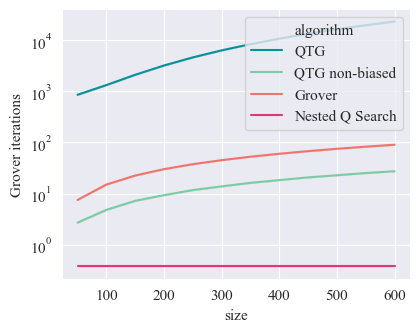

In [25]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.lineplot(grover_iteration_dfs, x="size", y="grover_iterations", hue="algorithm", hue_order=[
    "QTG", "QTG non-biased", "Grover", "Nested Q Search"
], ax=ax)
ax.set_yscale('log')

ax.set_ylabel("Grover iterations")